# Treinamento e comparação dos modelos

Objetivo: Treinar vários modelos com vários datasets para comparar os resultados.

In [1]:
#Installing SageMaker modules
!pip install s3fs==2022.01.0
%pip install phik
%pip install imblearn
%pip install yellowbrick

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
Note: you may need to re

In [2]:
#Importing the used modules
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import phik
sns.set_palette('viridis')
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, mean_absolute_error, mean_squared_error, r2_score, ConfusionMatrixDisplay
from yellowbrick.classifier import ConfusionMatrix
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, ExtraTreesClassifier
from sklearn.metrics import roc_curve
import joblib
import os
import warnings, requests, zipfile, io
from scipy.io import arff
import boto3
import sagemaker
from sagemaker.image_uris import retrieve
warnings.filterwarnings("ignore") #Filtering some warnings for better presentation

### 1. Carregando os datasets

In [3]:
#Loading the datasets
test_sets = ['numeric','categoricals_binned','one_hot_encoded','outliers_removed',
             'one_hot_encoded_rescaled','oversampled+','oversampled-','smoted+','smoted-']
datasets = {}
for key in test_sets:
    datasets[key] = pd.read_csv(f's3://trabalho-ifsp-campinas-interdisciplinar-2022-2/{key}.csv')

In [4]:
#Defining the X,y spliter
def df_splitter(dataset, target = 'Response'):
    X = dataset.drop(columns=[target])
    y = dataset[target].values
    return X, y

In [5]:
# Defining the printing function
def display_scores(scores):
    print("Scores:", scores)
    print("\nMean:", scores.mean())
    print("Standard deviation:", scores.std())

### 2. Testando os datasets

Como temos várias opções de datasets, nós vamos fazer um teste rápido dos modelos para ter uma noção dos resultados, para selecionar futuros modelos.

In [6]:
first_results = []

#### 2.1 Classificador K-Neighbors (KNN)

In [7]:
knn_clf = KNeighborsClassifier(n_neighbors=5, n_jobs = -1)
for key in test_sets:
    X, y = df_splitter(datasets[key])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1216)
    knn_test = cross_val_score(knn_clf,X_train,y_train, n_jobs=-1, cv=3, scoring='accuracy')
    first_results.append({'model':'KNN', 'dataset':key, 'score':knn_test.mean()})
    print(f'\n-----\nDataset: {key}')
    display_scores(knn_test)


-----
Dataset: numeric
Scores: [0.71228536 0.71211675 0.71491745]

Mean: 0.7131065181467098
Standard deviation: 0.0012823729935557734

-----
Dataset: categoricals_binned
Scores: [0.71022183 0.70769458 0.71012677]

Mean: 0.7093477245030178
Standard deviation: 0.0011695969120584819

-----
Dataset: one_hot_encoded
Scores: [0.71022183 0.70850531 0.70953715]

Mean: 0.7094214273332063
Standard deviation: 0.0007055284432189075

-----
Dataset: outliers_removed
Scores: [0.71475655 0.70724399 0.71301221]

Mean: 0.711670917757777
Standard deviation: 0.00321029198290776

-----
Dataset: one_hot_encoded_rescaled
Scores: [0.71464367 0.71395932 0.71587559]

Mean: 0.7148261929129059
Standard deviation: 0.0007928897487709854

-----
Dataset: oversampled+
Scores: [0.62038204 0.6198303  0.6208    ]

Mean: 0.620337448371037
Standard deviation: 0.0003971309629555497

-----
Dataset: oversampled-
Scores: [0.61266322 0.611905   0.6137282 ]

Mean: 0.6127654698725807
Standard deviation: 0.0007478214047553315

--

#### 2.2 Classificador Bayesiano Ingênuo Gaussiano (Gaussian Naive Bayes)

In [8]:
nbg_clf = GaussianNB()
for key in test_sets:
    X, y = df_splitter(datasets[key])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1216)
    nbg_test = cross_val_score(nbg_clf,X_train,y_train, n_jobs=-1, cv=5, scoring='accuracy')
    first_results.append({'model':'Naive Bayes', 'dataset':key, 'score':nbg_test.mean()})
    print(f'\n-----\nDataset: {key}')
    display_scores(nbg_test)


-----
Dataset: numeric
Scores: [0.75592679 0.74695983 0.74462597 0.75113622 0.74695983]

Mean: 0.7491217295172583
Standard deviation: 0.003998162378626328

-----
Dataset: categoricals_binned
Scores: [0.75690947 0.74953937 0.74376612 0.75224174 0.746837  ]

Mean: 0.749858739712566
Standard deviation: 0.004510973372125921

-----
Dataset: one_hot_encoded
Scores: [0.75506695 0.74941653 0.7443803  0.7492937  0.74867952]

Mean: 0.7493673995823609
Standard deviation: 0.003401088891060924

-----
Dataset: outliers_removed
Scores: [0.75418227 0.75156055 0.74956305 0.75402672 0.7445374 ]

Mean: 0.7507739966071254
Standard deviation: 0.003554625483263591

-----
Dataset: one_hot_encoded_rescaled
Scores: [0.72583221 0.72976293 0.72816607 0.71919912 0.72288417]

Mean: 0.725168898169758
Standard deviation: 0.003778530191324014

-----
Dataset: oversampled+
Scores: [0.52828054 0.53139394 0.53373737 0.52711111 0.52864646]

Mean: 0.5298338863750629
Standard deviation: 0.0024044679324950508

-----
Dataset

#### 2.3 Classificador Máquina Vetores de Suporte (Support Vector Machine)

In [9]:
svm = SVC(random_state = 1216, C = 1.0, cache_size = 1024)
for key in test_sets:
    X, y = df_splitter(datasets[key])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1216)
    svc_test = cross_val_score(svm,X_train,y_train, n_jobs=-1, cv=2, scoring='accuracy')
    first_results.append({'model':'Support Vector Machine', 'dataset':key, 'score':svc_test.mean()})
    print(f'\n-----\nDataset: {key}')
    display_scores(svc_test)


-----
Dataset: numeric
Scores: [0.76037931 0.76036753]

Mean: 0.7603734183543323
Standard deviation: 5.88690779129708e-06

-----
Dataset: categoricals_binned
Scores: [0.76037931 0.76036753]

Mean: 0.7603734183543323
Standard deviation: 5.88690779129708e-06

-----
Dataset: one_hot_encoded
Scores: [0.76037931 0.76036753]

Mean: 0.7603734183543323
Standard deviation: 5.88690779129708e-06

-----
Dataset: outliers_removed
Scores: [0.76038753 0.76038753]

Mean: 0.7603875349580503
Standard deviation: 0.0

-----
Dataset: one_hot_encoded_rescaled
Scores: [0.76037931 0.76036753]

Mean: 0.7603734183543323
Standard deviation: 5.88690779129708e-06

-----
Dataset: oversampled+
Scores: [0.5166462  0.53096516]

Mean: 0.5238056758678648
Standard deviation: 0.007159480250824246

-----
Dataset: oversampled-
Scores: [0.50775245 0.50517394]

Mean: 0.5064631951570698
Standard deviation: 0.0012892521197188644

-----
Dataset: smoted+
Scores: [0.67318508 0.66920939]

Mean: 0.6711972331760294
Standard deviatio

#### 2.4 Árvores de decisão

In [10]:
dtc = DecisionTreeClassifier(random_state=1216)
for key in test_sets:
    X, y = df_splitter(datasets[key])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1216)
    dtc_test = cross_val_score(dtc,X_train,y_train, n_jobs=-1, cv=2, scoring='accuracy')
    first_results.append({'model':'Decision Tree', 'dataset':key, 'score':dtc_test.mean()})
    print(f'\n-----\nDataset: {key}')
    display_scores(dtc_test)


-----
Dataset: numeric
Scores: [0.66545472 0.66273585]

Mean: 0.664095286587949
Standard deviation: 0.00135943753134532

-----
Dataset: categoricals_binned
Scores: [0.63725249 0.64042846]

Mean: 0.6388404763047
Standard deviation: 0.001587982814796829

-----
Dataset: one_hot_encoded
Scores: [0.64398369 0.640625  ]

Mean: 0.6423043439542082
Standard deviation: 0.0016793439542082123

-----
Dataset: outliers_removed
Scores: [0.64627447 0.64372753]

Mean: 0.6450009988014382
Standard deviation: 0.0012734718337994444

-----
Dataset: one_hot_encoded_rescaled
Scores: [0.64378716 0.640625  ]

Mean: 0.6422060783422592
Standard deviation: 0.0015810783422591235

-----
Dataset: oversampled+
Scores: [0.72916801 0.73243261]

Mean: 0.7308003102980154
Standard deviation: 0.0016322968517680225

-----
Dataset: oversampled-
Scores: [0.73010972 0.73479846]

Mean: 0.7324540897191807
Standard deviation: 0.0023443728806024633

-----
Dataset: smoted+
Scores: [0.68391622 0.68598487]

Mean: 0.6849505462537979
S

#### 2.5 Árvores Extras

In [11]:
extrees = ExtraTreesClassifier(n_jobs=-1, random_state=1216)
for key in test_sets:
    X, y = df_splitter(datasets[key])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1216)
    extrees_test = cross_val_score(extrees,X_train,y_train, n_jobs=-1, cv=3, scoring='accuracy')
    first_results.append({'model':'Extra Trees', 'dataset':key, 'score':extrees_test.mean()})
    print(f'\n-----\nDataset: {key}')
    display_scores(extrees_test)


-----
Dataset: numeric
Scores: [0.74839708 0.74985259 0.75081073]

Mean: 0.7496868023515727
Standard deviation: 0.0009923175815198183

-----
Dataset: categoricals_binned
Scores: [0.73793205 0.73776533 0.73540684]

Mean: 0.7370347402699734
Standard deviation: 0.0011531100974619445

-----
Dataset: one_hot_encoded
Scores: [0.71648611 0.72435142 0.72199292]

Mean: 0.7209434825543427
Standard deviation: 0.0032956294397047925

-----
Dataset: outliers_removed
Scores: [0.71857678 0.72222638 0.71848079]

Mean: 0.7197613160341841
Standard deviation: 0.0017435067655318006

-----
Dataset: one_hot_encoded_rescaled
Scores: [0.71648611 0.72435142 0.72199292]

Mean: 0.7209434825543427
Standard deviation: 0.0032956294397047925

-----
Dataset: oversampled+
Scores: [0.83142636 0.83515152 0.83369697]

Mean: 0.8334249466447662
Standard deviation: 0.0015329061255170064

-----
Dataset: oversampled-
Scores: [0.83439271 0.82925988 0.83753819]

Mean: 0.8337302586526795
Standard deviation: 0.003411913276928968


#### 2.6 Floresta aleatória

In [12]:
rnd_clf = RandomForestClassifier(n_estimators=70,
                                 max_leaf_nodes=None,
                                 bootstrap=True,
                                 oob_score=True,n_jobs = -1,
                                 random_state = 1216)
for key in test_sets:
    X, y = df_splitter(datasets[key])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1216)
    rnd_clf_test = cross_val_score(rnd_clf,X_train,y_train, n_jobs=-1, cv=3, scoring='accuracy')
    first_results.append({'model':'Random Forest', 'dataset':key, 'score':rnd_clf_test.mean()})
    print(f'\n-----\nDataset: {key}')
    display_scores(rnd_clf_test)


-----
Dataset: numeric
Scores: [0.75488245 0.75670696 0.7550855 ]

Mean: 0.7555583018265367
Standard deviation: 0.0008164410781646076

-----
Dataset: categoricals_binned
Scores: [0.7478812  0.7499263  0.74985259]

Mean: 0.7492200304343605
Standard deviation: 0.0009471742677313469

-----
Dataset: one_hot_encoded
Scores: [0.74471221 0.75051592 0.75014741]

Mean: 0.7484585123768754
Standard deviation: 0.002653303283560516

-----
Dataset: outliers_removed
Scores: [0.74883895 0.75016855 0.75031838]

Mean: 0.7497752930568754
Standard deviation: 0.0006649128782569847

-----
Dataset: one_hot_encoded_rescaled
Scores: [0.74478591 0.75051592 0.7500737 ]

Mean: 0.7484585105663065
Standard deviation: 0.002603189114267456

-----
Dataset: oversampled+
Scores: [0.82846892 0.83612121 0.8326303 ]

Mean: 0.8324068126234713
Standard deviation: 0.003128028585296697

-----
Dataset: oversampled-
Scores: [0.83178123 0.82743668 0.82970336]

Mean: 0.8296404227649076
Standard deviation: 0.0017742117696808272

-

#### 2.7 AdaBoost

In [ ]:
ada_boost = AdaBoostClassifier(n_estimators = 500, learning_rate = 0.8, random_state = 1216)
for key in test_sets:
    X, y = df_splitter(datasets[key])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1216)
    ada_boost_test = cross_val_score(ada_boost,X_train,y_train, n_jobs=-1, cv=3, scoring='accuracy')
    first_results.append({'model':'AdaBoost', 'dataset':key, 'score':ada_boost_test.mean()})
    print(f'\n-----\nDataset: {key}')
    display_scores(ada_boost_test)


-----
Dataset: numeric
Scores: [0.75945169 0.75980248 0.75906545]

Mean: 0.7594398719611991
Standard deviation: 0.0003010065924008337

-----
Dataset: categoricals_binned
Scores: [0.75996757 0.75980248 0.75994988]

Mean: 0.7599066438784113
Standard deviation: 7.401075954548328e-05

-----
Dataset: one_hot_encoded
Scores: [0.75989388 0.75980248 0.75987618]

Mean: 0.7598575104688545
Standard deviation: 3.957989254669246e-05

-----
Dataset: outliers_removed
Scores: [0.76022472 0.76028167 0.76020676]

Mean: 0.760237715066819
Standard deviation: 3.193349830681007e-05

-----
Dataset: one_hot_encoded_rescaled
Scores: [0.75989388 0.75980248 0.75994988]

Mean: 0.7598820780789174
Standard deviation: 6.0753578180248605e-05

-----
Dataset: oversampled+
Scores: [0.56530592 0.56213333 0.55873939]

Mean: 0.5620595506113203
Standard deviation: 0.0026812825313568974

-----
Dataset: oversampled-
Scores: [0.56132052 0.55627279 0.55533655]

Mean: 0.5576432883196627
Standard deviation: 0.0026281390582369975

#### 2.8 Analisando os resultados

In [ ]:
#Printing results comparison chart
results = first_results
results = pd.DataFrame(results)
results = results.pivot(index='model', columns = 'dataset', values = 'score')
results = results.reindex(columns= [ 'numeric','categoricals_binned','one_hot_encoded','one_hot_encoded_rescaled','outliers_removed','oversampled+','oversampled-','smoted+','smoted-'])
results = results.reindex(['KNN', 'Naive Bayes', 'Support Vector Machine', 'Decision Tree', 'Extra Trees', 'Random Forest', 'AdaBoost'])
results.style.background_gradient(cmap='bwr_r', low=0.7, high=0.8, axis=0)

dataset,numeric,categoricals_binned,one_hot_encoded,one_hot_encoded_rescaled,outliers_removed,oversampled+,oversampled-,smoted+,smoted-
model,,,,,,,,,
KNN,0.713107,0.709348,0.709421,0.714826,0.711671,0.620337,0.612765,0.616281,0.651036
Naive Bayes,0.749122,0.749859,0.749367,0.725169,0.750774,0.529834,0.534287,0.735228,0.634644
Support Vector Machine,0.760373,0.760373,0.760373,0.760373,0.760388,0.523806,0.506463,0.671197,0.505067
Decision Tree,0.664095,0.638840,0.642304,0.642206,0.645001,0.730800,0.732454,0.684951,0.730237
Extra Trees,0.749687,0.737035,0.720943,0.720943,0.719761,0.833425,0.833730,0.758517,0.786722
Random Forest,0.755558,0.749220,0.748459,0.748459,0.749775,0.832407,0.829640,0.770735,0.805545
AdaBoost,0.759440,0.759907,0.759858,0.759882,0.760238,0.562060,0.557643,0.755899,0.817929


O gráfico de resultado mostra que os melhores resultados foram com:
* Árvores extras com o dataset 'oversampled-'
* Floresta aleatória com o dataset 'oversampled+'
* AdaBoost com o dataset 'smoted-'

Algumas observações já podem ser feitas:

* Máquina de Vetores de Suporte e AdaBoost tiveram bons resultados de plano com os datasets não reamostrados.
* Árvore de Decisão teve resultados melhores com os datasets reamostrados.
* Floresta aleatória teve melhores resultados com o dataset rebalanceado.
* Os modelos foram significativamente piores usando o SMOTE Borderline e RobustScaler, do que simplesmente removendo os outliers.
* AdaBoost se beneficiou bastante dos dados reamostrados usando o SMOTE.
* Árvores extras e Floresta aleatória tiveram resultados próximos.

### 3. Usando Grid Search com os modelos

#### 3.1 Árvores Extras

In [14]:
pass

In [15]:
#Preparing the classifier
extra_tree = ExtraTreesClassifier(n_estimators=1000, random_state=1216, n_jobs = -1)
X, y = df_splitter(datasets['oversampled-'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1216)

In [16]:
#Setting the parameters for the grid search
min_samples_split = np.array([2,10,40])
max_depth = np.array([10,50,100,None])
max_leaf_nodes = np.array([5,20,None])
values_grid = {'min_samples_split': min_samples_split,
               'max_depth': max_depth,
               'max_leaf_nodes':max_leaf_nodes}

In [17]:
#Using grid search to find the best values
gridExtraTrees = GridSearchCV(estimator = extra_tree,
                                param_grid = values_grid,
                                cv = 2, verbose = 3,
                                scoring='accuracy',
                                pre_dispatch=-1)
gridExtraTrees.fit(X_train, y_train);

Fitting 2 folds for each of 36 candidates, totalling 72 fits
[CV 1/2] END max_depth=10, max_leaf_nodes=5, min_samples_split=2;, score=0.568 total time=   4.8s
[CV 2/2] END max_depth=10, max_leaf_nodes=5, min_samples_split=2;, score=0.559 total time=   3.8s
[CV 1/2] END max_depth=10, max_leaf_nodes=5, min_samples_split=10;, score=0.568 total time=   3.9s
[CV 2/2] END max_depth=10, max_leaf_nodes=5, min_samples_split=10;, score=0.559 total time=   3.8s
[CV 1/2] END max_depth=10, max_leaf_nodes=5, min_samples_split=40;, score=0.568 total time=   3.9s
[CV 2/2] END max_depth=10, max_leaf_nodes=5, min_samples_split=40;, score=0.559 total time=   3.8s
[CV 1/2] END max_depth=10, max_leaf_nodes=20, min_samples_split=2;, score=0.579 total time=   5.0s
[CV 2/2] END max_depth=10, max_leaf_nodes=20, min_samples_split=2;, score=0.573 total time=   5.0s
[CV 1/2] END max_depth=10, max_leaf_nodes=20, min_samples_split=10;, score=0.579 total time=   6.4s
[CV 2/2] END max_depth=10, max_leaf_nodes=20, min

In [18]:
extra_trees_results = pd.DataFrame(gridExtraTrees.cv_results_)
extra_trees_results.sort_values(by=['mean_test_score'], ascending=False)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_leaf_nodes,param_min_samples_split,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
15,19.557127,0.248432,3.059871,0.017751,50,None,2,"{'max_depth': 50, 'max_leaf_nodes': None, 'min...",0.778990,0.777570,0.778280,0.000710,1
24,18.902565,0.076367,3.028806,0.047899,100,None,2,"{'max_depth': 100, 'max_leaf_nodes': None, 'mi...",0.778563,0.777898,0.778230,0.000332,2
33,18.458100,0.033251,2.986384,0.032299,None,None,2,"{'max_depth': None, 'max_leaf_nodes': None, 'm...",0.778563,0.777898,0.778230,0.000332,2
16,14.386444,0.967928,2.685699,0.150103,50,None,10,"{'max_depth': 50, 'max_leaf_nodes': None, 'min...",0.734380,0.739003,0.736692,0.002312,4
34,13.417561,0.075139,2.412341,0.081944,None,None,10,"{'max_depth': None, 'max_leaf_nodes': None, 'm...",0.734183,0.739003,0.736593,0.002410,5
25,13.564093,0.033898,2.378015,0.028300,100,None,10,"{'max_depth': 100, 'max_leaf_nodes': None, 'mi...",0.734183,0.739003,0.736593,0.002410,5
26,11.221017,0.916721,1.984831,0.144197,100,None,40,"{'max_depth': 100, 'max_leaf_nodes': None, 'mi...",0.671934,0.674978,0.673456,0.001522,7
17,10.286388,0.000425,1.875069,0.060216,50,None,40,"{'max_depth': 50, 'max_leaf_nodes': None, 'min...",0.671934,0.674978,0.673456,0.001522,7
35,10.184495,0.051770,1.948672,0.148584,None,None,40,"{'max_depth': None, 'max_leaf_nodes': None, 'm...",0.671934,0.674978,0.673456,0.001522,7
6,6.315168,0.041363,1.324761,0.004174,10,None,2,"{'max_depth': 10, 'max_leaf_nodes': None, 'min...",0.618586,0.609178,0.613882,0.004704,10


In [19]:
print(gridExtraTrees.best_estimator_)

ExtraTreesClassifier(max_depth=50, n_estimators=1000, n_jobs=-1,
                     random_state=1216)


In [20]:
best_extra_trees = gridExtraTrees.best_estimator_
best_extra_trees.fit(X_train, y_train);

In [21]:
teste_xtr = best_extra_trees.predict(X_test)
print(classification_report(y_test, teste_xtr))

              precision    recall  f1-score   support

           0       0.93      0.87      0.90      7581
           1       0.88      0.93      0.91      7640

    accuracy                           0.90     15221
   macro avg       0.91      0.90      0.90     15221
weighted avg       0.91      0.90      0.90     15221



Após fazer grid search com alguns parâmetros, o modelo de árvores extras teve um resultado significativo com o seu melhor resultado.

#### 3.2 Floresta aleatória

In [22]:
#Setting the Classifier
rand_forest = RandomForestClassifier(criterion='gini',
                                 max_leaf_nodes=None,
                                 bootstrap=True,
                                 oob_score=True,
                                 n_jobs = -1)
X, y = df_splitter(datasets['oversampled+'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1216)

In [23]:
# Grid search parameters
n_estimators = np.array([1000,2000])
max_depth = np.array([50,None])
values_grid_forest = {'n_estimators': n_estimators, 'max_depth': max_depth}

In [24]:
#Using grid search to find the best values
gridForest = GridSearchCV(estimator = rand_forest,
                                param_grid = values_grid_forest,
                                cv = 2, verbose = 3,
                                scoring='accuracy',
                                pre_dispatch=-1)
gridForest.fit(X_train, y_train);

Fitting 2 folds for each of 4 candidates, totalling 8 fits
[CV 1/2] END ...max_depth=50, n_estimators=1000;, score=0.779 total time=  25.5s
[CV 2/2] END ...max_depth=50, n_estimators=1000;, score=0.781 total time=  27.4s
[CV 1/2] END ...max_depth=50, n_estimators=2000;, score=0.779 total time=  49.4s
[CV 2/2] END ...max_depth=50, n_estimators=2000;, score=0.781 total time=  49.2s
[CV 1/2] END .max_depth=None, n_estimators=1000;, score=0.779 total time=  24.5s
[CV 2/2] END .max_depth=None, n_estimators=1000;, score=0.782 total time=  24.5s
[CV 1/2] END .max_depth=None, n_estimators=2000;, score=0.780 total time=  51.0s
[CV 2/2] END .max_depth=None, n_estimators=2000;, score=0.781 total time=  48.2s


In [25]:
forest_results = pd.DataFrame(gridForest.cv_results_)
forest_results.sort_values(by=['mean_test_score'], ascending=False)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
2,21.744000,0.019804,2.776633,0.016335,None,1000,"{'max_depth': None, 'n_estimators': 1000}",0.778751,0.781725,0.780238,0.001487,1
3,44.187776,1.349858,5.425279,0.034221,None,2000,"{'max_depth': None, 'n_estimators': 2000}",0.779721,0.780690,0.780206,0.000485,2
0,23.523984,1.000075,2.937289,0.086378,50,1000,"{'max_depth': 50, 'n_estimators': 1000}",0.778557,0.781272,0.779915,0.001358,3
1,43.851890,0.100667,5.444205,0.015103,50,2000,"{'max_depth': 50, 'n_estimators': 2000}",0.778622,0.780981,0.779802,0.001180,4


In [26]:
print(gridForest.best_estimator_)

RandomForestClassifier(n_estimators=1000, n_jobs=-1, oob_score=True)


In [27]:
best_forest = gridForest.best_estimator_
best_forest.fit(X_train, y_train);

In [28]:
teste_rnd = best_forest.predict(X_test)
print(classification_report(y_test, teste_rnd))

              precision    recall  f1-score   support

           0       0.93      0.88      0.90      7680
           1       0.89      0.93      0.91      7790

    accuracy                           0.91     15470
   macro avg       0.91      0.91      0.91     15470
weighted avg       0.91      0.91      0.91     15470



Após fazer grid search com alguns parâmetros, o floresta aleatória foi ligeiramente melhor.

#### 3.3 AdaBoost

In [29]:
#Setting the classifier
ada_boost = AdaBoostClassifier(random_state = 1216)
X, y = df_splitter(datasets['smoted-'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1216)

In [30]:
n_estimators = np.array([200,300,600])
learning_rate = np.array([1.0,1.5])
values_grid_ada = {'n_estimators': n_estimators, 'learning_rate': learning_rate}

In [31]:
#Using grid search to find the best values
gridAda = GridSearchCV(estimator = ada_boost,
                                param_grid = values_grid_ada,
                                cv = 2, verbose = 3,
                                scoring='accuracy',
                                pre_dispatch=-1)
gridAda.fit(X_train, y_train);

Fitting 2 folds for each of 6 candidates, totalling 12 fits
[CV 1/2] END learning_rate=1.0, n_estimators=200;, score=0.814 total time=   5.6s
[CV 2/2] END learning_rate=1.0, n_estimators=200;, score=0.815 total time=   5.7s
[CV 1/2] END learning_rate=1.0, n_estimators=300;, score=0.817 total time=   8.6s
[CV 2/2] END learning_rate=1.0, n_estimators=300;, score=0.817 total time=   8.5s
[CV 1/2] END learning_rate=1.0, n_estimators=600;, score=0.817 total time=  16.9s
[CV 2/2] END learning_rate=1.0, n_estimators=600;, score=0.818 total time=  17.2s
[CV 1/2] END learning_rate=1.5, n_estimators=200;, score=0.817 total time=   5.8s
[CV 2/2] END learning_rate=1.5, n_estimators=200;, score=0.818 total time=   5.6s
[CV 1/2] END learning_rate=1.5, n_estimators=300;, score=0.817 total time=   8.3s
[CV 2/2] END learning_rate=1.5, n_estimators=300;, score=0.817 total time=   8.4s
[CV 1/2] END learning_rate=1.5, n_estimators=600;, score=0.817 total time=  16.9s
[CV 2/2] END learning_rate=1.5, n_esti

In [32]:
ada_results = pd.DataFrame(gridAda.cv_results_)
ada_results.sort_values(by=['mean_test_score'], ascending=False)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_n_estimators,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
2,13.795679,0.090203,3.272072,0.049937,1.0,600,"{'learning_rate': 1.0, 'n_estimators': 600}",0.817489,0.818041,0.817765,0.000276,1
3,4.605990,0.048476,1.102190,0.039973,1.5,200,"{'learning_rate': 1.5, 'n_estimators': 200}",0.817390,0.817549,0.817470,0.000079,2
1,6.880895,0.048205,1.627450,0.001925,1.0,300,"{'learning_rate': 1.0, 'n_estimators': 300}",0.817259,0.817384,0.817322,0.000063,3
4,6.754956,0.015219,1.596301,0.010586,1.5,300,"{'learning_rate': 1.5, 'n_estimators': 300}",0.817423,0.817089,0.817256,0.000167,4
5,13.540156,0.105683,3.223916,0.008620,1.5,600,"{'learning_rate': 1.5, 'n_estimators': 600}",0.816799,0.817122,0.816960,0.000161,5
0,4.561684,0.060821,1.089756,0.006902,1.0,200,"{'learning_rate': 1.0, 'n_estimators': 200}",0.814335,0.814724,0.814530,0.000194,6


In [33]:
print(gridAda.best_estimator_)

AdaBoostClassifier(n_estimators=600, random_state=1216)


In [34]:
best_ada = gridAda.best_estimator_
best_ada.fit(X_train, y_train);

In [35]:
teste_ada = best_ada.predict(X_test)
print(classification_report(y_test, teste_ada))

              precision    recall  f1-score   support

           0       0.75      0.95      0.84      7581
           1       0.93      0.68      0.79      7640

    accuracy                           0.82     15221
   macro avg       0.84      0.82      0.81     15221
weighted avg       0.84      0.82      0.81     15221



Já o AdaBoost não melhorou usando grid search.

### 4. Validação cruzada

#### 4.1 Árvores aleatórias

In [6]:
#Treina o best_extra_trees - REMOVER DEPOIS DE PRONTO
X, y = df_splitter(datasets['oversampled-'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1216)
best_extra_trees = ExtraTreesClassifier(max_depth=50, n_estimators=1000, n_jobs=-1,
                     random_state=1216)
best_extra_trees.fit(X_train, y_train);

In [35]:
pass

In [36]:
#Validação cruzada das árvores aleatórias
X, y = df_splitter(datasets['oversampled-'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)#Sem seed fixa para treinar em novos estados.
extrees = ExtraTreesClassifier(max_depth=50,n_estimators=1000)#Sem seed fixa para treinar em novos estados.
extrees_test = cross_val_score(extrees,X_train,y_train, n_jobs=-1, cv=2, scoring='accuracy') #Apenas 2 validações cruzadas para evitar que a instância seja terminada por exceder a memória alocada.
display_scores(extrees_test)

Scores: [0.77803692 0.77510594]

Mean: 0.7765714326578845
Standard deviation: 0.0014654900147387795


A validação cruzada não demosntrou melhora significativa na validação cruzada.

In [37]:
#Exibindo o relatório de classificação
X, y = df_splitter(datasets['oversampled-'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1216)
teste_xtr = best_extra_trees.predict(X_test)
print(classification_report(y_test, teste_xtr))

              precision    recall  f1-score   support

           0       0.93      0.87      0.90      7581
           1       0.88      0.93      0.91      7640

    accuracy                           0.90     15221
   macro avg       0.91      0.90      0.90     15221
weighted avg       0.91      0.90      0.90     15221



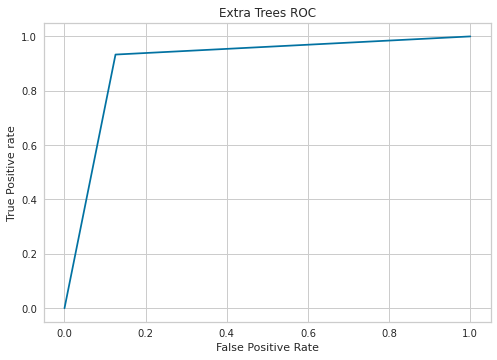

In [38]:
#Gerando o gráfico ROC
X, y = df_splitter(datasets['oversampled-'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1216)
y_pred = best_extra_trees.predict(X_test)
fpr, tpr, thresh = roc_curve(y_test, y_pred, pos_label=1)
plt.plot(fpr, tpr, label='Extra Trees ROC')
plt.title('Extra Trees ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate');

0.9038827935089678

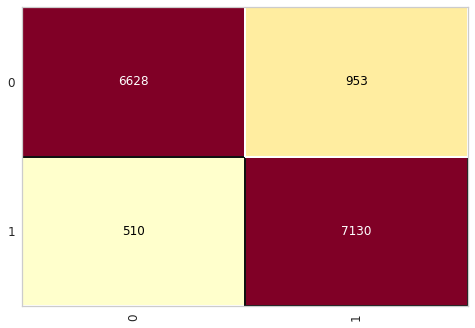

In [39]:
#Exibindo a matriz de confusão
cm = ConfusionMatrix(best_extra_trees)
cm.fit(X_train, y_train)
cm.score(X_test, y_test)

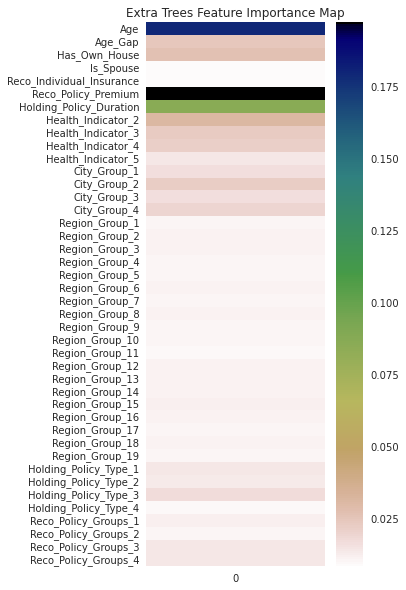

In [40]:
#Exibindo o mapa de importância das variáveis
feature_imp = pd.DataFrame(best_extra_trees.feature_importances_, index = X.columns)
plt.figure(figsize = (4,10))
sns.heatmap(feature_imp, annot=False, cmap='gist_earth_r').set(title='Extra Trees Feature Importance Map');

A árvore de importância do árvores extras em seu melhor resultado demonstra que as características mais imporantes foram : O prêmio do seguro, a idade do cliente, e há quanto tempo o cliente já faz parte da operadora ('Holding_Policy_Duration')

#### 4.2 Random forest

In [7]:
#Treina o best_forest - remover depois
X, y = df_splitter(datasets['oversampled+'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1216)
best_forest = RandomForestClassifier(n_estimators=1000, oob_score=True)
best_forest.fit(X_train, y_train);

In [40]:
pass

In [41]:
# Validação cruzada da floresta aleatória
X, y = df_splitter(datasets['oversampled+'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)#Sem seed fixa para treinar em novos estados.
rand_forest = RandomForestClassifier(criterion='gini',
                                     max_leaf_nodes=None,
                                     bootstrap=True,
                                     oob_score=True,
                                     n_estimators=1000)#Sem seed fixa para treinar em novos estados.
rand_forest_test = cross_val_score(rand_forest,X_train,y_train, n_jobs=-1, cv=3, scoring='accuracy') #Only 3 to avoid excessive memory overload of our instance
display_scores(rand_forest_test)

Scores: [0.83690488 0.83369697 0.83471515]

Mean: 0.8351056661838006
Standard deviation: 0.0013384180065090826


In [42]:
#Exibindo o relatório de classificação
X, y = df_splitter(datasets['oversampled+'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1216)
teste_rnd = best_forest.predict(X_test)
print(classification_report(y_test, teste_rnd))

              precision    recall  f1-score   support

           0       0.93      0.88      0.90      7680
           1       0.89      0.93      0.91      7790

    accuracy                           0.91     15470
   macro avg       0.91      0.91      0.91     15470
weighted avg       0.91      0.91      0.91     15470



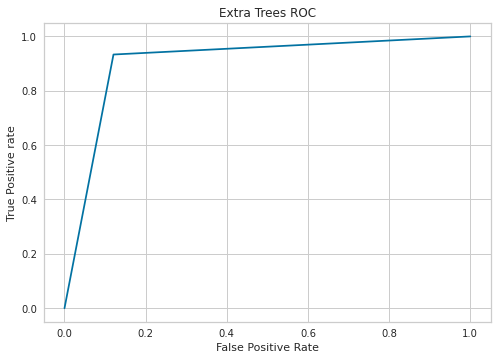

In [43]:
#Gerando o gráfico ROC
X, y = df_splitter(datasets['oversampled+'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1216)
y_pred = best_forest.predict(X_test)
fpr, tpr, thresh = roc_curve(y_test, y_pred, pos_label=1)
plt.plot(fpr, tpr, label='Random Forest ROC')
plt.title('Extra Trees ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate');

0.9065287653522948

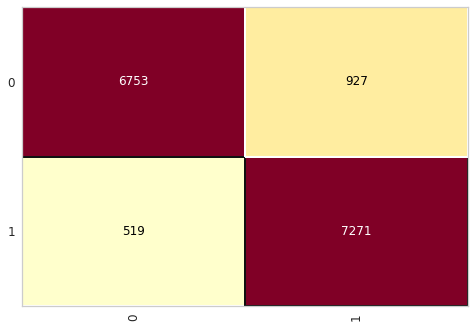

In [44]:
#Exibindo a matriz de confusão
cm = ConfusionMatrix(best_forest)
cm.fit(X_train, y_train)
cm.score(X_test, y_test)

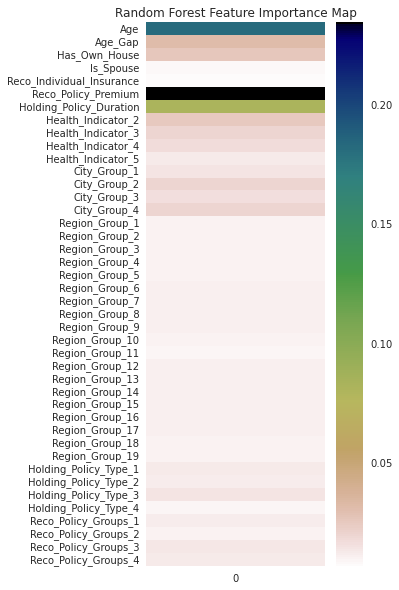

In [45]:
#Exibindo o mapa de importância das variáveis
feature_imp = pd.DataFrame(best_forest.feature_importances_, index = X.columns)
plt.figure(figsize = (4,10))
sns.heatmap(feature_imp, annot=False, cmap='gist_earth_r').set(title='Random Forest Feature Importance Map');

Já o o modelo de floresta aleatória deu muito mais importância para o preço do seguro (observar a escala).

#### 4.3 Comparação dos melhores modelos com os outros datasets

In [45]:
pass

In [46]:
last_results = []

In [ ]:
#Comparando o modelo de árvores aleatórias com os outros datasets
for key in test_sets:
    X, y = df_splitter(datasets[key])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
    best_extra_trees_test = cross_val_score(best_extra_trees,X_train,y_train, n_jobs=-1, cv=2, scoring='accuracy')
    last_results.append({'model':'Extra Trees', 'dataset':key, 'score':best_extra_trees_test.mean()})
    print(f'\n-----\nDataset: {key}')
    display_scores(best_extra_trees_test)


-----
Dataset: numeric
Scores: [0.75224369 0.75131027 0.75137579]

Mean: 0.7516432511422361
Standard deviation: 0.00042541930863307115


In [ ]:
#Comparando o modelo de floresta aleatória com os outros datasets
for key in test_sets:
    X, y = df_splitter(datasets[key])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
    best_forest_test = cross_val_score(best_forest,X_train,y_train, n_jobs=-1, cv=2, scoring='accuracy')
    last_results.append({'model':'Random Forest', 'dataset':key, 'score':best_forest_test.mean()})
    print(f'\n-----\nDataset: {key}')
    display_scores(best_forest_test)

In [ ]:
#Gerando a tabela de comparação
results = last_results
results = pd.DataFrame(results)
results = results.pivot(index='model', columns = 'dataset', values = 'score')
results = results.reindex(columns= [ 'numeric','categoricals_binned','one_hot_encoded','one_hot_encoded_rescaled','outliers_removed','oversampled+','oversampled-','smoted+','smoted-'])
results = results.reindex(['Random Forest','Extra Trees'])
results

In [ ]:
#Gerando o mapa de calor de comparação
plt.figure(figsize = (13,2))
sns.heatmap(results, annot=True, fmt='.4g',cmap='coolwarm_r', vmin=0.717, vmax=0.834).set(title='Best models dataset comparison');

In [ ]:
#Mostrando o resultado médio dos modelos
print(results.mean(axis=1))

Após comparar os modelos com os outros datasets, mas dessa vez sem usar o mesmo seed state para a divisão dos conjuntos, observa-se que os modelos se mantiveram relativamente acurados para os para os datasets rebalanceados com o random oversampler, sem significativa diferença com o robust scaler.

Já os dados rebalanceados usando o SMOTE Borderline não tiveram resultados próximos, embora o Floresta aleatória conseguiu se manter próximo.

Os valores de acurácia excelentes de 0.90 e 0.91 indicam a ser provável o overfitting.

Porém, os resultados do último teste demonstram que esse é um valor mais próximo do que seria esperado em um modelo em produção.

A título de comparação, seguem alguns resultados de competidores do Kaggle:

| Modelo | Valores |
| --- | --- |
| Random Forest | 0.81, 0.90 |
| Extra Trees | 0.85 |
| XGB | 0.82 |
| AdaBoost | 0.59 |
| PyTorch | 0.75 |

### 5. Endpoint do Amazon Sagemaker

#### 5.1 Preparando os dados para o pipeline

O dataset que apresentou melhor resultados foi o "oversampled+". Iremos preparar esse dataset para uso com um estimator do Sagemaker.

In [42]:
#Copiando o dataset e reorganizando as colunas
df = datasets['oversampled+'].copy()
cols = df.columns.tolist()
cols = cols[-1:] + cols[:-1]
df = df[cols]
df.columns #Checando para ver se 'Response' (a variável alvo) é a primeira coluna, como esperado.

Index(['Response', 'Age', 'Age_Gap', 'Has_Own_House', 'Is_Spouse',
       'Reco_Individual_Insurance', 'Reco_Policy_Premium',
       'Holding_Policy_Duration', 'Health_Indicator_2', 'Health_Indicator_3',
       'Health_Indicator_4', 'Health_Indicator_5', 'City_Group_1',
       'City_Group_2', 'City_Group_3', 'City_Group_4', 'Region_Group_1',
       'Region_Group_2', 'Region_Group_3', 'Region_Group_4', 'Region_Group_5',
       'Region_Group_6', 'Region_Group_7', 'Region_Group_8', 'Region_Group_9',
       'Region_Group_10', 'Region_Group_11', 'Region_Group_12',
       'Region_Group_13', 'Region_Group_14', 'Region_Group_15',
       'Region_Group_16', 'Region_Group_17', 'Region_Group_18',
       'Region_Group_19', 'Holding_Policy_Type_1', 'Holding_Policy_Type_2',
       'Holding_Policy_Type_3', 'Holding_Policy_Type_4',
       'Reco_Policy_Groups_1', 'Reco_Policy_Groups_2', 'Reco_Policy_Groups_3',
       'Reco_Policy_Groups_4'],
      dtype='object')

In [44]:
#Separando em conjuntos de treino, validação e teste
train, test_and_validate = train_test_split(df, test_size=0.3, random_state=1216)
test, validate = train_test_split(test_and_validate, test_size=0.5, random_state=1216)
print(f'Tamanho do conjunto de treino: {train.shape}.\nTamanho do conjunto de validação: {validate.shape}.\nTamanho do conjunto de teste:{test.shape}')



Tamanho do conjunto de treino: (54142, 43).
Tamanho do conjunto de validação: (11602, 43).
Tamanho do conjunto de teste:(11602, 43)


In [48]:
#Ajustando parâmetros para criar o endpoint
bucket='trabalho-ifsp-campinas-interdisciplinar-2022-2'
prefix='SageMakerEndpoint'
train_file='xgb_train.csv'
test_file='xgb_test.csv'
validate_file='xgb_validate.csv'

In [51]:
#Definindo a função para fazer o upload do CSV
s3_resource = boto3.Session().resource('s3')
def upload_s3_csv(filename, folder, dataframe):
    csv_buffer = io.StringIO()
    dataframe.to_csv(csv_buffer, header=False, index=False)
    s3_resource.Bucket(bucket).Object(os.path.join(prefix, folder, filename)).put(Body=csv_buffer.getvalue())

In [52]:
upload_s3_csv(train_file, 'train', train)
upload_s3_csv(test_file, 'test', test)
upload_s3_csv(validate_file, 'validate', validate)

#### Treinando o modelo

In [55]:
container = retrieve('xgboost',boto3.Session().region_name,'1.0-1')
#Hiperparâmetros do XGBoost
hyperparams={"num_round":"42",
             "eval_metric": "auc",
             "objective": "binary:logistic"}

In [64]:
#Criando o modelo de treinamento para o XGBoost
s3_output_location="s3://{}/{}/output/".format(bucket,prefix)
xgb_model=sagemaker.estimator.Estimator(container,
                                       sagemaker.get_execution_role(),
                                       instance_count=1,
                                       instance_type='ml.m4.xlarge',
                                       output_path=s3_output_location,
                                        hyperparameters=hyperparams,
                                        sagemaker_session=sagemaker.Session())

In [65]:
#Creating the data channels
train_channel = sagemaker.inputs.TrainingInput(
    "s3://{}/{}/train/".format(bucket,prefix,train_file),
    content_type='text/csv')

validate_channel = sagemaker.inputs.TrainingInput(
    "s3://{}/{}/validate/".format(bucket,prefix,validate_file),
    content_type='text/csv')
data_channels = {'train': train_channel, 'validation': validate_channel}

In [66]:
xgb_model.fit(inputs=data_channels, logs=False)


2022-12-07 01:03:16 Starting - Starting the training job.......
2022-12-07 01:03:53 Starting - Preparing the instances for training..................
2022-12-07 01:05:30 Downloading - Downloading input data...........
2022-12-07 01:06:31 Training - Downloading the training image........
2022-12-07 01:07:16 Training - Training image download completed. Training in progress...
2022-12-07 01:07:32 Uploading - Uploading generated training model..
2022-12-07 01:07:48 Completed - Training job completed


#### Testando o modelo

In [67]:
#Carregando o preditor XGB
xgb_predictor = xgb_model.deploy(initial_instance_count=1,
                serializer = sagemaker.serializers.CSVSerializer(),
                instance_type='ml.m4.xlarge')

--------!

In [73]:
#Testando se funciona com uma linha primeiro
row = test.iloc[0:1,1:]
batch_X_csv_buffer = io.StringIO()
row.to_csv(batch_X_csv_buffer, header=False, index=False)
test_row = batch_X_csv_buffer.getvalue()
xgb_predictor.predict(test_row)


b'0.5912033319473267'

In [76]:
#Verificando se o estimador acertou
test.iloc[0:1,:1]

,Response
27898,0


In [78]:
#Terminando a instância
xgb_predictor.delete_endpoint(delete_endpoint_config=True)

#### Testando em lotes para verificar a predição

In [80]:
batch_X = test.iloc[:,1:]; #Removendo a variável target do conjunto
batch_X_file='batch-in.csv'
upload_s3_csv(batch_X_file, 'batch-in', batch_X)

In [81]:
#Criando os diretórios de entrada e saída de lote
batch_output = "s3://{}/{}/batch-out/".format(bucket,prefix)
batch_input = "s3://{}/{}/batch-in/{}".format(bucket,prefix,batch_X_file)

In [84]:
#Criando o transformador
xgb_transformer = xgb_model.transformer(instance_count=1,
                                       instance_type='ml.m4.xlarge',
                                       strategy='MultiRecord',
                                       assemble_with='Line',
                                       output_path=batch_output)

In [85]:
#Chamando o preditor
xgb_transformer.transform(data=batch_input,
                         data_type='S3Prefix',
                         content_type='text/csv',
                         split_type='Line')
xgb_transformer.wait()

.................................
[2022-12-07:01:53:01:INFO] No GPUs detected (normal if no gpus installed)
[2022-12-07:01:53:01:INFO] No GPUs detected (normal if no gpus installed)
[2022-12-07:01:53:01:INFO] nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;
worker_rlimit_nofile 4096;
events {
  worker_connections 2048;
}
http {
  include /etc/nginx/mime.types;
  default_type application/octet-stream;
  access_log /dev/stdout combined;
  upstream gunicorn {
    server unix:/tmp/gunicorn.sock;
  }
  server {
    listen 8080 deferred;
    client_max_body_size 0;
    keepalive_timeout 3;
    location ~ ^/(ping|invocations|execution-parameters) {
      proxy_set_header X-Forwarded-For $proxy_add_x_forwarded_for;
      proxy_set_header Host $http_host;
      proxy_redirect off;
      proxy_read_timeout 60s;
      proxy_pass http://gunicorn;
    }
    location / {
      return 404 "{}";
    }
  }
}
[2022-12-07 01:53:02 +0000] [19] [INFO] Starting g

In [86]:
#Carregando os resultados preditos
s3 = boto3.client('s3')
obj = s3.get_object(Bucket=bucket, Key="{}/batch-out/{}".format(prefix,'batch-in.csv.out'))
target_predicted = pd.read_csv(io.BytesIO(obj['Body'].read()),',',names=['class'])
target_predicted.head(5)

,class
0,0.591203
1,0.508470
2,0.397219
3,0.350950
4,0.588040


In [88]:
#Aplicando a transformação binária para os resultados carregados
def binary_convert(x):
    threshold = 0.7
    if x > threshold:
        return 1
    else:
        return 0

target_predicted['binary'] = target_predicted['class'].apply(binary_convert)

print(target_predicted.head(10))
test.head(10)

      class  binary
0  0.591203       0
1  0.508470       0
2  0.397219       0
3  0.350950       0
4  0.588040       0
5  0.235196       0
6  0.627811       0
7  0.575025       0
8  0.546832       0
9  0.382361       0


,Response,Age,Age_Gap,Has_Own_House,Is_Spouse,Reco_Individual_Insurance,Reco_Policy_Premium,Holding_Policy_Duration,Health_Indicator_2,Health_Indicator_3,...,Region_Group_18,Region_Group_19,Holding_Policy_Type_1,Holding_Policy_Type_2,Holding_Policy_Type_3,Holding_Policy_Type_4,Reco_Policy_Groups_1,Reco_Policy_Groups_2,Reco_Policy_Groups_3,Reco_Policy_Groups_4
27898,0,75,0,0,0,1,0.958409,14,1,0,...,0,0,0,0,1,0,0,0,0,1
9229,0,48,0,1,0,1,-0.406193,4,0,0,...,0,0,0,1,0,0,0,0,1,0
73617,1,44,8,0,1,0,1.661392,5,0,0,...,0,0,0,0,1,0,1,0,0,0
20595,1,32,0,0,0,1,-0.074367,4,1,0,...,0,0,1,0,0,0,0,1,0,0
30880,0,33,0,1,0,1,-0.167043,8,0,0,...,0,0,0,0,1,0,0,0,0,1
27359,0,75,0,1,0,1,0.611890,4,0,0,...,1,0,0,1,0,0,0,0,0,0
66826,1,36,0,1,0,1,0.129295,15,1,0,...,0,0,0,0,1,0,0,1,0,0
7782,1,49,0,0,0,1,-0.121835,0,1,0,...,0,0,0,0,0,0,0,1,0,0
61647,1,39,1,0,1,0,0.724458,0,1,0,...,0,0,0,0,0,0,1,0,0,0
64460,1,45,0,0,0,1,-0.408002,0,1,0,...,0,0,0,0,0,0,0,0,0,0


Verificando os resultados

In [93]:
target_predicted_backup = target_predicted.copy()

In [96]:
target_predicted.drop(columns = 'class', inplace=True)

In [101]:
target_predicted['binary']

0        0
1        0
2        0
3        0
4        0
        ..
11597    0
11598    0
11599    0
11600    0
11601    1
Name: binary, Length: 11602, dtype: int64

In [99]:
test['Response']

27898    0
9229     0
73617    1
20595    1
30880    0
        ..
14227    0
34433    0
55501    1
49542    1
40484    0
Name: Response, Length: 11602, dtype: int64

In [102]:
print(classification_report(target_predicted['binary'], test['Response']))

              precision    recall  f1-score   support

           0       0.98      0.51      0.67     11115
           1       0.07      0.79      0.12       487

    accuracy                           0.52     11602
   macro avg       0.52      0.65      0.40     11602
weighted avg       0.94      0.52      0.65     11602

